# Question 1


## (a)

In [42]:
P_neg_given_M = 0.05
P_pos_given_notM = 0.05
P_notM = 0.99

## (b)

In [43]:
# want to figure out P[M|+]
# we can use bayes equation which says P[M|+] = P[+|M] * P[M] / P[+]
# P[M|+] = 0.95 * 0.01 / P[+]
# we know P[+] = P(+ and M) + P(+ and notM)
# so P[+] = P[+|M] * P[M] + P[+|not M] * P[not M] = 0.95 * 0.01 + 0.05 * 0.99 = 0.059
# then P[M|+] = 0.95 * 0.01 / 0.059 = 0.161

# 16.1% chance

## (c)

In [44]:
# P[M|+] = 0.95 * 0.1 / P[+]
# P[+] = P[+|M] * P[M] + P[+|not M] * P[not M] = 0.95 * 0.1 + 0.05 * 0.9 = 0.14
# then P[M|+] = 0.95 * 0.1 / 0.14 = 0.678

# 67.8% chance

# Question 2

## (a)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [46]:
class NaiveBayesClassifier():
    def __init__(self):
        self.cls = []
        self.cls_stats = []
        self.prior_prob = []
        self.trained = False
    
    @staticmethod
    def gaussian(X, mean, std):
        """
        Gaussain probability distribution function
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        mean: numpy.ndarray
            Average of each feature, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature, shape (n_features,)
            
        Returns
        -------
        prob: numpy.ndarray
            Probability of each feature, shape (n_samples, n_features)
        """
        norm = 1 / np.sqrt(2 * np.pi * std**2)
        prob = norm * np.exp(-(X - mean)**2 / (2 * std**2))
        return prob
    
    @staticmethod
    def calculate_statistics(X):
        """
        Calculate the average and standard deviation of each feature based on the input data
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
            
        Returns
        -------
        mean: numpy.ndarray
            Average of each feature, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature, shape (n_features,)
        """
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        return mean, std
    
    @staticmethod
    def calculate_prob(X, mean, std):
        """
        Calculate the prior probability that the input features belong to a specific class,
        i.e. P(X | C) = \prod_i P(X_i | C)
        which is defined by the statistics of features in that class.
        
        Gaussain probability distribution function
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        mean: numpy.ndarray
            Average of each feature in the speific class, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature in the specific class, shape (n_features,)
            
        Returns
        -------
        prob: numpy.ndarray
            Probability that the features belong to a spcefic class, shape (n_samples,)
        """
        prob = np.product(
            NaiveBayesClassifier.gaussian(X, mean, std),
            axis=1
        )
        return prob
    
    def fit(self, X, y):
        """
        Train the classifier by calculating the statistics of different features in each class
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        y: numpy.ndarray
            Labels (the actual classes), shape (n_samples)
        """
        ndata = y.shape[0]
        self.cls = np.unique(y)
        for i in range(len(self.cls)):
            cls_filter = (y == self.cls[i])
            self.prior_prob.append(np.sum(cls_filter) / ndata)
            self.cls_stats.append(NaiveBayesClassifier.calculate_statistics(X[cls_filter]))
        self.trained = True
            
    def predict(self, X):
        # Do the prediction by outputing the class that has highest probability
        assert self.trained, f"The classfier has not been trained. Call {self.__class__.__name__}.fit first"
        probs = [
            self.calculate_prob(X, *self.cls_stats[i]) * self.prior_prob[i] for i in range(len(self.cls))
        ]
        return self.cls[np.argmax(probs, axis=0)]

We choose to use a gaussian to represent the PDF because it mirrors the statistical patterns of many real-life scenarios. Also the gaussian naive bayes has feature independence. 

In [119]:
classifier = NaiveBayesClassifier()
df = pd.read_csv("wines.csv")

new = df[df['Alcohol %'] >= 12.9]
alc13 = new[new['Alcohol %'] <= 13.5]
rank1_and_alc13 = alc13[alc13['ranking'] == 1]
rank1_and_alc13_array = rank1_and_alc13[['Alcohol %', 'ranking']].values

new = df[df['ranking'] == 1]
alcohol = new[["Alcohol %"]].values
mean, std = classifier.calculate_statistics(alcohol)
prob = classifier.gaussian(13, mean, std)

print(prob)

[0.23236758]


## (b)

Preprocess data:
+ Select relevant descriptors (columns other than "Start assignment" and "ranking"). Should get *178 datapoints and 13 features*.
+ Normalize the data with `StandardScaler` in sklearn.
+ The labels are in the "ranking" column.

*For debugging*: The accuracy could reach over 95\%.

In [78]:
from sklearn.model_selection import train_test_split, KFold

def calculate_accuracy(model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = np.sum(y_pred == y) / len(y)
    return acc

def KFoldNaiveBayes(k, X, y):
    """
    K-Fold Cross Validation for Naive Bayes Classifier
    
    Parameters
    ---------
    k: int
        Number of folds
    X: numpy.ndarray
        Input data, shape (n_samples, n_features)
    y: numpy.ndarray
        Class labels, shape (n_samples)
    """
    
        
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_all = []
    test_acc_all = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = NaiveBayesClassifier()
        
        # Report prediction accuracy for this fold
        # use the calculate_accuracy() function
        train_acc = calculate_accuracy(model, X_train, y_train)
        train_acc_all.append(train_acc)
        test_acc = calculate_accuracy(model, X_test, y_test)
        test_acc_all.append(test_acc)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
    
    # report mean & std for the training/testing accuracy
    print("Final results:")
    print(f"Training accuracy:, {np.mean(train_acc_all)}+/-{np.std(train_acc_all)}")
    print(f"Testing  accuracy:, {np.mean(test_acc_all)}+/-{np.std(test_acc_all)}")

In [80]:
from sklearn.preprocessing import StandardScaler

features = df.drop(['Start assignment', 'ranking'], axis=1)
X = StandardScaler().fit_transform(features)
y = df['ranking']
KFoldNaiveBayes(3, X, y)

Train accuracy: 0.9915254237288136
Test accuracy: 0.9833333333333333
Train accuracy: 0.9831932773109243
Test accuracy: 0.9661016949152542
Train accuracy: 0.9831932773109243
Test accuracy: 1.0
Final results:
Training accuracy:, 0.9859706594502208+/-0.0039278114892858
Testing  accuracy:, 0.9831450094161959+/-0.013839565776616691


# Question 3

## (a)

In [81]:
import torch
import torch.nn as nn

In [117]:
# Define your model here

softmax = nn.Softmax(dim=1)
cross_entropy = nn.CrossEntropyLoss()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # create a net with one hidden layer
        # input_dim 13, hidden_dim 3, output_dim 3
        # use ReLU and softmax activation func
        self.layers = nn.Sequential(
            nn.Linear(13,3), # only the weights times input plus bias
            nn.Softmax(dim=1)
        )
    
    def forward(self, X):
        return self.layers(X)


model = Net()

In [118]:
features = df.drop(['Start assignment', 'ranking'], axis=1).values
X = StandardScaler().fit_transform(features)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(df['ranking'].values - 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# define loss
loss_func = nn.CrossEntropyLoss()

epochs = 1 # feed forward 1 times
for _ in range(epochs):
    y_pred = model(X_train)
    print(y_pred)
    loss = loss_func(y_pred, y_train)
    
    with torch.no_grad():
        test_loss = loss_func(model(X_test), y_test)
        print(test_loss.item())

tensor([[0.5908, 0.2483, 0.1609],
        [0.4446, 0.3020, 0.2534],
        [0.4503, 0.3298, 0.2199],
        [0.2749, 0.2275, 0.4976],
        [0.4568, 0.3520, 0.1912],
        [0.5177, 0.2484, 0.2340],
        [0.1615, 0.3919, 0.4467],
        [0.3648, 0.4472, 0.1880],
        [0.2613, 0.2679, 0.4708],
        [0.6392, 0.2361, 0.1246],
        [0.2248, 0.3737, 0.4015],
        [0.4571, 0.2612, 0.2817],
        [0.3313, 0.3128, 0.3559],
        [0.3761, 0.2799, 0.3440],
        [0.4273, 0.4028, 0.1699],
        [0.1694, 0.2256, 0.6051],
        [0.4551, 0.3873, 0.1576],
        [0.3698, 0.2558, 0.3744],
        [0.2646, 0.2573, 0.4781],
        [0.4918, 0.2523, 0.2559],
        [0.3549, 0.2655, 0.3796],
        [0.4919, 0.2867, 0.2214],
        [0.4795, 0.2658, 0.2546],
        [0.2616, 0.2889, 0.4494],
        [0.2400, 0.2336, 0.5264],
        [0.3406, 0.3089, 0.3505],
        [0.4203, 0.3718, 0.2078],
        [0.3063, 0.3077, 0.3861],
        [0.1628, 0.2255, 0.6117],
        [0.505

The softmax activaiton function is applied to the final layer in the neural network to convert it into probabilites. It doesn't affect the loss function much, but it affects the predicted y-values. With softmax, all the predicted y-values are below 1 and are probability values. Without softmax, the predicted y-values can exceed 1.

## (b)

*For debugging*: The accuracy could reach over 95\% if the hyperparamters are tuned properly.

In [115]:
def train_and_val(model, X_train, y_train, epochs, draw_curve=True):
    """
    Further split the data into acutal train and validation subsets.
    """
    # Define your loss function, optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    
    X_train_in, X_val, y_train_in, y_val = train_test_split(X, y, test_size=0.2)
    
    val_losses = []
    lowest_val_loss = np.inf
    
    weights = {}
    for i in range(epochs):
        # Compute the loss and do back-propagation
        y_train_pred = model(X_train_in)
        loss = loss_func(y_train_pred, y_train_in)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute validation loss and keep track of the lowest val loss
        with torch.no_grad():
            val_loss = loss_func(model(X_val), y_val)
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            weights = model.state_dict() 
        val_losses.append(val_loss)
        
    # The final number of epochs is when the minimum error in validation set occurs    
    final_epochs = np.argmin(val_losses)
    print("Number of epochs with lowest validation:", final_epochs)
    print(f"Validation loss: {np.min(val_losses)}")
    # Recover the model weights
    model.load_state_dict(weights)

    if draw_curve:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
        ax.plot(np.arange(epochs), val_losses, label='Validation loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
    
    return model


def calculate_accuracy_nn(model, X, y):
    with torch.no_grad():
        y_pred = torch.argmax(model(X), axis=1)
        acc = torch.sum(y_pred == y) / len(y)
    return acc.detach().numpy()


def KFoldNN(k, X, y, epochs=500):
    """
    K-Fold Validation for Neural Network
    
    Parameters
    ---------
    k: int
        Number of folds
    X: numpy.ndarray
        Input data, shape (n_samples, n_features)
    y: numpy.ndarray
        Class labels, shape (n_samples)
    epochs: int
        Number of epochs during training
    """
    # K-Fold
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_all = []
    test_acc_all = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # further do a train/valid split on X_train
        model = train_and_val(Net(), X_train, y_train, epochs)
        
        # Report prediction accuracy for this fold
        # use calculate_accuracy_nn() function
        train_acc = calculate_accuracy_nn(model, X_train, y_train)
        train_acc_all.append(train_acc)
        test_acc = calculate_accuracy_nn(model, X_test, y_test)
        test_acc_all.append(test_acc)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
    
    # report mean & std for the training/testing accuracy
    print("Final results:")
    print(f"Training accuracy: {np.mean(train_acc_all)}+/-{np.std(train_acc_all)}")
    print(f"Testing  accuracy:, {np.mean(test_acc_all)}+/-{np.std(test_acc_all)}")

Number of epochs with lowest validation: 499
Validation loss: 0.056678831577301025
Train accuracy: 0.9915254
Test accuracy: 1.0
Number of epochs with lowest validation: 499
Validation loss: 0.08388963341712952
Train accuracy: 0.99159664
Test accuracy: 1.0
Number of epochs with lowest validation: 499
Validation loss: 0.03717653825879097
Train accuracy: 1.0
Test accuracy: 0.9830508
Final results:
Training accuracy: 0.9943740367889404+/-0.003978277090936899
Testing  accuracy:, 0.994350254535675+/-0.007989917881786823


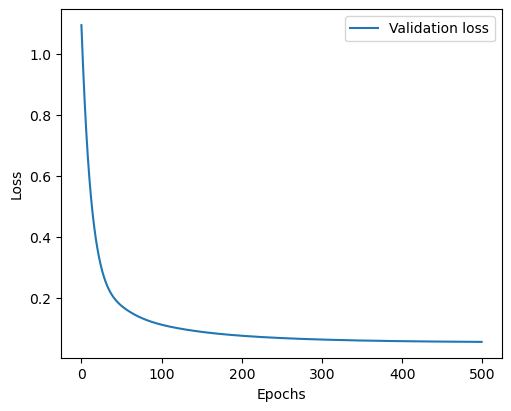

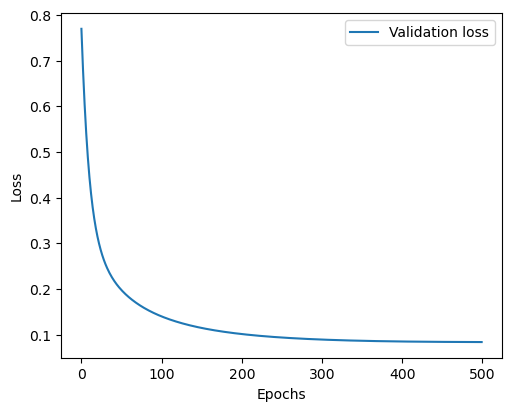

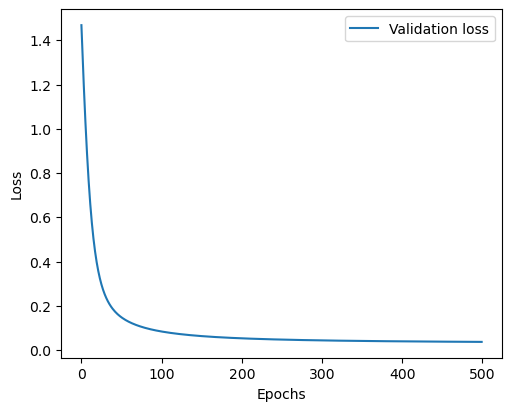

In [116]:
KFoldNN(3, X, y, epochs=500)

Both the training and testing success rate is about 99%. The validation loss is also quite low with one fold haveing a validaiton loss of 0.056. This is much lower than the loss in problem two which was around 1.18 with softmax. 